In [1]:
import pandas as pd
from pathlib import Path

# Root path where your exports live
ROOT = Path("./db_exports")

# Map logical DB names to their export folders
DB_FOLDERS = {
    "csbotdb": ROOT / "chatbotdb_2025-12-02_16-43-03",
    "chatwoot": ROOT / "chatwoot_production_2025-12-02_16-43-03",
}

def load_db_folder(folder_path: Path) -> dict:
    """
    Load all .csv.gz files in a folder into a dict of DataFrames.
    
    Keys are table names (filename without .csv.gz).
    """
    tables = {}

    for file in sorted(folder_path.glob("*.csv.gz")):
        table_name = file.name.replace(".csv.gz", "")
        print(f"Loading {folder_path.name}/{file.name} -> table '{table_name}'")

        df = pd.read_csv(file, compression="infer")
        tables[table_name] = df

    return tables

# Main dict: db_name -> { table_name -> DataFrame }
db_data = {}

for db_name, folder in DB_FOLDERS.items():
    if not folder.exists():
        raise FileNotFoundError(f"Folder not found for {db_name}: {folder}")
    print(f"\n=== Loading database: {db_name} from {folder} ===")
    db_data[db_name] = load_db_folder(folder)

# Optional: unpack into convenience variables
csbotdb = db_data["csbotdb"]
chatwoot = db_data["chatwoot"]

# Quick sanity checks
print("\ncsbotdb tables:", list(csbotdb.keys()))
print("chatwoot tables:", list(chatwoot.keys()))

# Example: peek at some important tables
csbotdb["sessions"].head()


=== Loading database: csbotdb from db_exports/chatbotdb_2025-12-02_16-43-03 ===
Loading chatbotdb_2025-12-02_16-43-03/agent_notes.csv.gz -> table 'agent_notes'
Loading chatbotdb_2025-12-02_16-43-03/appointment_form.csv.gz -> table 'appointment_form'
Loading chatbotdb_2025-12-02_16-43-03/cancel_form.csv.gz -> table 'cancel_form'
Loading chatbotdb_2025-12-02_16-43-03/conversation_context.csv.gz -> table 'conversation_context'
Loading chatbotdb_2025-12-02_16-43-03/essential_context.csv.gz -> table 'essential_context'
Loading chatbotdb_2025-12-02_16-43-03/messages.csv.gz -> table 'messages'
Loading chatbotdb_2025-12-02_16-43-03/reprogramar_form.csv.gz -> table 'reprogramar_form'
Loading chatbotdb_2025-12-02_16-43-03/scheduled_templates.csv.gz -> table 'scheduled_templates'
Loading chatbotdb_2025-12-02_16-43-03/sessions.csv.gz -> table 'sessions'
Loading chatbotdb_2025-12-02_16-43-03/users.csv.gz -> table 'users'

=== Loading database: chatwoot from db_exports/chatwoot_production_2025-12-0

,id,user_id,start_time,end_time,status,conv_id,bot_feedback,agent_feedback,created_at,bot_phone_number,waiting_for_first_template_delivery,first_template_id,first_template_sent_time,scheduled_template_sent,scheduled_template_autosend_time,scheduled_template_to_be_sent,last_user_reply_time
0,50,1,2025-10-28 00:33:08.415751+00,2025-10-28 01:02:57.309927+00,closed,233.0,NaN,NaN,2025-10-28 00:33:08.415754+00,6.372061e+14,f,wamid.HBgMNTczMTEzNzcxODI3FQIAERgSMzZDMzVGRjBE...,2025-10-28 00:33:09.264922+00,NaN,NaN,NaN,NaN
1,25,2,2025-10-22 21:01:15.447877+00,2025-10-23 13:50:48.339044+00,closed,198.0,NaN,NaN,2025-10-22 21:01:15.447884+00,6.372061e+14,f,NaN,NaN,NaN,NaN,NaN,NaN
2,641,326,2025-11-13 13:31:29.896718+00,2025-11-14 13:21:32.275703+00,closed,NaN,NaN,NaN,2025-11-13 13:31:29.89672+00,8.315141e+14,f,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,2025-09-30 15:13:27.146537+00,2025-09-30 15:20:54.047225+00,closed,174.0,5.0,5.0,2025-09-30 15:13:27.146543+00,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
4,48,1,2025-10-28 00:07:39.95679+00,2025-10-28 00:09:53.103436+00,closed,229.0,NaN,NaN,2025-10-28 00:07:39.956793+00,6.372061e+14,f,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
chatwoot["canned_responses"].keys()

Index(['id', 'account_id', 'short_code', 'content', 'created_at',
       'updated_at'],
      dtype='object')

In [ ]:
# 1. - **Conversations per day on avg** without the off days.

#    - Convs opened and closed on avg per day NO this sucks

#   - convs per day, per hour, messages per min,

#  - we need to see avg number of convs by day, we need to see if there is an increase wrt 
# previous computed daily mean except for saturdays which are only till 12 so ofc we have very little traffic. 
# We need to be able to quickly perceive if there is an increase of chats. wrt to previous traffic.

In [24]:
import pandas as pd
import numpy as np

# --- SETTINGS ----------------------------------------------------------

LOCAL_TZ = "America/Bogota"

# Study window (inclusive, in LOCAL TIME)
START_DATE_LOCAL = "2025-11-13"
END_DATE_LOCAL   = "2025-12-01"

# Off days to fully exclude from averages
OFF_DATES = set([
    "2025-11-17"
])

# Whatsapp IDs to exclude
EXCLUDED_WHATSAPP_IDS = set([
    "573113771827", "573136314648",
    "573105399139", "573174378162"
])

# ----------------------------------------------------------------------


# --- PREP DATA --------------------------------------------------------

sessions = csbotdb["sessions"].copy()
users = csbotdb["users"].copy()

# Remove excluded users
if EXCLUDED_WHATSAPP_IDS:
    users_to_exclude = users[users["whatsapp_id"].astype(str).isin(EXCLUDED_WHATSAPP_IDS)]["id"].tolist()
    sessions = sessions[~sessions["user_id"].isin(users_to_exclude)]

# Convert timestamps from UTC → Colombian local time
for col in ["start_time", "end_time"]:
    sessions[col] = (
        pd.to_datetime(sessions[col], utc=True)
        .dt.tz_convert(LOCAL_TZ)
    )

# Local date (YYYY-MM-DD string)
sessions["date"] = sessions["start_time"].dt.strftime("%Y-%m-%d")


# --- FILTER: DATE WINDOW ----------------------------------------------

# Keep only sessions whose LOCAL start_date is within window
sessions = sessions[
    (sessions["date"] >= START_DATE_LOCAL) &
    (sessions["date"] <= END_DATE_LOCAL)
]


# --- REMOVE OFF-DAYS ---------------------------------------------------

def filter_off_days(df):
    if not OFF_DATES:
        return df
    return df[~df["date"].isin(OFF_DATES)]

sessions = filter_off_days(sessions)


# --- DISPLAY BASIC INFO -----------------------------------------------

print(f"Study window: {START_DATE_LOCAL} → {END_DATE_LOCAL}")
print(f"Off days removed: {OFF_DATES if OFF_DATES else 'None'}")
print(f"Excluded whatsapp IDs: {EXCLUDED_WHATSAPP_IDS if EXCLUDED_WHATSAPP_IDS else 'None'}")
print(f"Remaining sessions: {len(sessions)}")
print(f"Date range found: {sessions['date'].min()} → {sessions['date'].max()}")

sessions.head()

Study window: 2025-11-13 → 2025-12-01
Off days removed: {'2025-11-17'}
Excluded whatsapp IDs: {'573113771827', '573105399139', '573174378162', '573136314648'}
Remaining sessions: 2088
Date range found: 2025-11-13 → 2025-12-01


,id,user_id,start_time,end_time,status,conv_id,bot_feedback,agent_feedback,created_at,bot_phone_number,waiting_for_first_template_delivery,first_template_id,first_template_sent_time,scheduled_template_sent,scheduled_template_autosend_time,scheduled_template_to_be_sent,last_user_reply_time,date
2,641,326,2025-11-13 08:31:29.896718-05:00,2025-11-14 08:21:32.275703-05:00,closed,NaN,NaN,NaN,2025-11-13 13:31:29.89672+00,8.315141e+14,f,NaN,NaN,NaN,NaN,NaN,NaN,2025-11-13
309,1031,579,2025-11-15 12:18:03.435071-05:00,2025-11-15 12:18:04.372998-05:00,closed,NaN,NaN,NaN,2025-11-15 17:18:03.435073+00,8.315141e+14,f,NaN,NaN,f,2025-11-18 12:00:00+00,seguimiento_mensaje,NaN,2025-11-15
465,676,352,2025-11-13 10:24:08.104916-05:00,2025-11-13 11:31:48.328773-05:00,closed,786.0,NaN,NaN,2025-11-13 15:24:08.104917+00,8.315141e+14,f,NaN,NaN,NaN,NaN,NaN,2025-11-13 15:24:37.493644+00,2025-11-13
595,665,345,2025-11-13 09:59:26.539190-05:00,2025-11-13 10:21:45.658388-05:00,closed,776.0,NaN,NaN,2025-11-13 14:59:26.539192+00,8.380580e+14,f,wamid.HBgMNTczMDIyNTA4MTY0FQIAERgSNkRERUFDNDdF...,2025-11-13 14:59:27.543271+00,NaN,NaN,NaN,NaN,2025-11-13
597,663,343,2025-11-13 09:52:54.476722-05:00,2025-11-13 11:00:46.504580-05:00,closed,774.0,5.0,5.0,2025-11-13 14:52:54.476724+00,8.756350e+14,f,NaN,NaN,NaN,NaN,NaN,2025-11-13 15:57:58.387498+00,2025-11-13


In [25]:
# --- PART 1: DAILY NEW CONVERSATIONS ---------------------------------

# A conversation is NEW on the date of the session start_time
daily_new = (
    sessions.groupby("date")["id"]
    .nunique()  # number of new sessions
    .rename("new_conversations")
    .to_frame()
)


# --- PART 2: DAILY ACTIVE CONVERSATIONS -------------------------------

# A conversation is ACTIVE on day X if:
# start_time <= end_of_day  AND (end_time is null OR end_time >= start_of_day)

# Build a per-day calendar window
all_dates = pd.date_range(
    start=sessions["start_time"].min().normalize(),
    end=sessions["start_time"].max().normalize(),
    freq="D",
    tz=LOCAL_TZ
)

records = []
for d in all_dates:
    day_start = d.replace(hour=0, minute=0, second=0)
    day_end   = d.replace(hour=23, minute=59, second=59)

    active = sessions[
        (sessions["start_time"] <= day_end) &
        (
            sessions["end_time"].isna() |
            (sessions["end_time"] >= day_start)
        )
    ]["id"].nunique()

    new   = daily_new.loc[str(d.date()), "new_conversations"] \
            if str(d.date()) in daily_new.index else 0

    records.append({
        "date": str(d.date()),
        "new_conversations": new,
        "active_conversations": active,
    })

traffic = pd.DataFrame(records)
traffic = filter_off_days(traffic)



In [26]:
# --- PART 3: SUMMARY STATS -------------------------------------------

evaluated_days = len(traffic)

summary = {
    "evaluated_days": evaluated_days,
    "total_new_conversations": traffic["new_conversations"].sum(),
    "avg_new_conversations_per_day": round(traffic["new_conversations"].mean(), 2),

    "active_convs_min": int(traffic["active_conversations"].min()),
    "active_convs_max": int(traffic["active_conversations"].max()),
    "active_convs_mean": round(traffic["active_conversations"].mean(), 2),
}

display(pd.DataFrame([summary]))


,evaluated_days,total_new_conversations,avg_new_conversations_per_day,active_convs_min,active_convs_max,active_convs_mean
0,18,2088,116.0,6,264,147.44


In [28]:
# --- PART 4: PER-DAY-OF-WEEK STATS ------------------------------------

# Add weekday
traffic["weekday"] = pd.to_datetime(traffic["date"]).dt.day_name()

weekday_stats = (
    traffic.groupby("weekday")
    .agg(
        days=("date", "count"),
        new_mean=("new_conversations", "mean"),
        new_min=("new_conversations", "min"),
        new_max=("new_conversations", "max"),
        active_mean=("active_conversations", "mean"),
        active_min=("active_conversations", "min"),
        active_max=("active_conversations", "max"),
    )
    .round(2)
)

display(weekday_stats)

,days,new_mean,new_min,new_max,active_mean,active_min,active_max
weekday,,,,,,,
Friday,3,134.00,115,170,177.00,147,222
Monday,2,168.50,159,178,178.50,173,184
Saturday,3,39.33,1,66,83.33,19,120
Sunday,3,6.33,6,7,17.67,6,33
Thursday,3,169.00,143,185,204.33,185,227
Tuesday,2,184.00,122,246,204.50,163,246
Wednesday,2,168.50,143,194,220.50,177,264


In [30]:
# --- PART 5: CORRECT HOURLY STATISTICS -------------------------------

# Take the final filtered sessions table
df = sessions.copy()

# Normalize days in local timezone
unique_days = pd.to_datetime(df["date"].unique())
unique_days = unique_days.tz_localize(LOCAL_TZ)

records = []

for day in unique_days:
    for h in range(24):

        hour_start = day.replace(hour=h, minute=0, second=0)
        hour_end   = hour_start + pd.Timedelta(hours=1) - pd.Timedelta(seconds=1)

        # New conversations: session starts inside this hour
        new_count = df[
            (df["start_time"] >= hour_start) &
            (df["start_time"] <= hour_end)
        ]["id"].nunique()

        # Active conversations: alive at any time during this hour
        active_count = df[
            (df["start_time"] <= hour_end) &
            (
                df["end_time"].isna() |
                (df["end_time"] >= hour_start)
            )
        ]["id"].nunique()

        records.append({
            "date": day.date().isoformat(),
            "hour": h,
            "new_conversations": new_count,
            "active_conversations": active_count
        })

hourly_df = pd.DataFrame(records)

# Aggregate per hour across all days
hourly_stats = (
    hourly_df.groupby("hour")
    .agg(
        days=("date", "nunique"),
        new_min=("new_conversations", "min"),
        new_mean=("new_conversations", "mean"),
        new_max=("new_conversations", "max"),
        active_min=("active_conversations", "min"),
        active_mean=("active_conversations", "mean"),
        active_max=("active_conversations", "max"),
    )
).round(2)

display(hourly_stats)

,days,new_min,new_mean,new_max,active_min,active_mean,active_max
hour,,,,,,,
0,18,0,0.00,0,0,31.44,70
1,18,0,0.11,1,0,31.56,70
2,18,0,0.06,1,0,31.61,71
3,18,0,0.06,1,0,31.67,71
4,18,0,0.06,1,0,31.72,71
5,18,0,0.11,2,0,31.83,71
6,18,0,1.17,3,0,33.06,74
7,18,0,7.28,29,1,40.28,79
8,18,0,11.67,27,1,45.28,93


In [ ]:
# new messages per hour of the day min max mean
# global for the time period:
# messages per min on average on working hours across all days.

#CHATOWOOT

In [52]:
import pandas as pd

LOCAL_TZ = "America/Bogota"
START_DATE_LOCAL = "2025-11-13"
END_DATE_LOCAL   = "2025-12-01"
HOLIDAY_EXCLUDE  = {"2025-11-17"}

WORK_START_WEEKDAY = 7
WORK_END_WEEKDAY   = 18

WORK_START_SAT = 8
WORK_END_SAT   = 11

msgs = chatwoot["messages"].copy()
msgs["created_at"] = pd.to_datetime(msgs["created_at"], utc=True).dt.tz_convert(LOCAL_TZ)
msgs["date"] = msgs["created_at"].dt.strftime("%Y-%m-%d")

msgs = msgs[(msgs["date"] >= START_DATE_LOCAL) & (msgs["date"] <= END_DATE_LOCAL)]
msgs = msgs[~msgs["date"].isin(HOLIDAY_EXCLUDE)]

msgs["weekday"] = msgs["created_at"].dt.weekday
msgs = msgs[msgs["weekday"] != 6]

incoming = msgs[
    (msgs["sender_type"] == "Contact") &
    (msgs["private"].astype(str) == "f") &
    (msgs["message_type"] == 0)
].copy()

incoming["hour"] = incoming["created_at"].dt.hour

unique_days = sorted(incoming["date"].unique())
recs = []

for d in unique_days:
    day = pd.to_datetime(d).tz_localize(LOCAL_TZ)
    wd  = day.weekday()
    for h in range(24):
        start = day.replace(hour=h, minute=0, second=0)
        end   = start + pd.Timedelta(hours=1) - pd.Timedelta(seconds=1)
        count = incoming[(incoming["created_at"] >= start) &
                         (incoming["created_at"] <= end)]["id"].count()
        recs.append({"date": d, "weekday": wd, "hour": h, "incoming_messages": count})

hourly_df = pd.DataFrame(recs)

hourly_stats = (
    hourly_df.groupby("hour")
    .agg(
        days=("date", "nunique"),
        incoming_min=("incoming_messages", "min"),
        incoming_mean=("incoming_messages", "mean"),
        incoming_max=("incoming_messages", "max"),
    )
).round(2)

display(hourly_stats)


def valid_working_mask(df):
    if df.empty:
        return df
    wd = df["weekday"]
    h  = df["hour"]
    wk = (wd >= 0) & (wd <= 4) & (h >= WORK_START_WEEKDAY) & (h <= WORK_END_WEEKDAY)
    sa = (wd == 5) & (h >= WORK_START_SAT) & (h <= WORK_END_SAT)
    return df[wk | sa]


work_df = hourly_df.copy()
work_df = valid_working_mask(work_df)

work_days = work_df["date"].nunique()

minutes_per_weekday = (WORK_END_WEEKDAY - WORK_START_WEEKDAY + 1) * 60
minutes_per_saturday = (WORK_END_SAT - WORK_START_SAT + 1) * 60

days_info = incoming[["date", "weekday"]].drop_duplicates()
days_info["is_weekday"] = days_info["weekday"].between(0,4)
days_info["is_sat"] = days_info["weekday"] == 5

num_weekdays = days_info["is_weekday"].sum()
num_saturdays = days_info["is_sat"].sum()

total_minutes = num_weekdays * minutes_per_weekday + num_saturdays * minutes_per_saturday
total_msgs = work_df["incoming_messages"].sum()

mpm = total_msgs / total_minutes if total_minutes > 0 else 0
mph = mpm * 60

global_stats = pd.DataFrame([{
    "study_window"           : f"{START_DATE_LOCAL} → {END_DATE_LOCAL}",
    "holiday_removed"        : list(HOLIDAY_EXCLUDE),
    "days_counted"           : work_days,
    "num_weekdays"           : num_weekdays,
    "num_saturdays"          : num_saturdays,
    "weekday_minutes_total"  : num_weekdays * minutes_per_weekday,
    "saturday_minutes_total" : num_saturdays * minutes_per_saturday,
    "total_working_minutes"  : total_minutes,
    "total_incoming_messages": total_msgs,
    "messages_per_minute"    : round(mpm, 6),
    "messages_per_hour"      : round(mph, 2),
}])

display(global_stats)

,days,incoming_min,incoming_mean,incoming_max
hour,,,,
0,15,0,0.00,0
1,15,0,0.13,1
2,15,0,0.07,1
3,15,0,0.13,2
4,15,0,0.13,2
5,15,0,0.33,3
6,15,0,2.53,6
7,15,1,45.20,116
8,15,27,90.73,164


,study_window,holiday_removed,days_counted,num_weekdays,num_saturdays,weekday_minutes_total,saturday_minutes_total,total_working_minutes,total_incoming_messages,messages_per_minute,messages_per_hour
0,2025-11-13 → 2025-12-01,[2025-11-17],15,12,3,8640,720,9360,11859,1.266987,76.02


In [ ]:
# First and last message per day of the agents.
# for each message sent by one of our agents we will compute lenght of the message in characters and infer the time taken to type it form avcergae human typing speed of a call center agent.
#  we need to count the number of messages sent per agent per day then also output the total time typing message = sum of time taken to type all messages in that day.

# then compute total time in chatwoot as follow: total time in a day inside chatwoot = total time typing message + 10s for assigning a conversation or resolving one or updating it in any way or form.
# I want to know in hour, minutes and second how long did the spend in chatwoot.

# then I want to plot activity curve for all my 4 agents, we will have a point in y axis = 1 if the user sent a message or did absolutly anything inside chatwoot like changed status, updates a conversation, created a contact , anything. Make sure we are thorugh with this.
# in the Y axis we will have time which is continuous and goes from 7 am to 6 pm in colombia time.





# down here is the time spent sending messages by the agents, the time sending canned responses is set to 5 seconds.

In [ ]:
# reading messages time by agent

In [61]:
import pandas as pd
from datetime import timedelta

LOCAL_TZ = "America/Bogota"
START_DATE_LOCAL = "2025-11-13"
END_DATE_LOCAL   = "2025-12-01"
HOLIDAY_EXCLUDE  = {"2025-11-17"}
TYPING_WPM = 40
READING_WPM = 250

agents_emails = {
    "andres.echeverri@chatwoot.com",
    "diana@chatwoot.com",
    "jenny@chatwoot.com",
    "viviana@chatwoot.com"
}

users = chatwoot["users"]
agents = users[users["email"].isin(agents_emails)][["id","email"]].copy()
agent_ids = set(agents["id"].astype(int).tolist())

messages = chatwoot["messages"].copy()
messages["created_at"] = pd.to_datetime(messages["created_at"], utc=True).dt.tz_convert(LOCAL_TZ)
messages["date"] = messages["created_at"].dt.strftime("%Y-%m-%d")
messages = messages[(messages["date"] >= START_DATE_LOCAL) & (messages["date"] <= END_DATE_LOCAL)]
messages = messages[~messages["date"].isin(HOLIDAY_EXCLUDE)]

canned = chatwoot["canned_responses"].copy()
canned_texts = set(canned["content"].astype(str).tolist())

agent_msgs = messages[
    (messages["sender_type"]=="User") &
    (messages["private"].astype(str)=="f") &
    (messages["message_type"]==1) &
    (messages["sender_id"].isin(agent_ids))
].copy()

agent_msgs["chars"] = agent_msgs["content"].astype(str).str.len()

cps_type = TYPING_WPM*5/60

def typing_time(row):
    txt = str(row["content"])
    if txt in canned_texts:
        return 5
    return row["chars"]/cps_type

agent_msgs["typing_seconds"] = agent_msgs.apply(typing_time, axis=1)
agent_msgs["weekday"] = agent_msgs["created_at"].dt.weekday

audits = chatwoot["audits"].copy()
audits["created_at"] = pd.to_datetime(audits["created_at"], utc=True).dt.tz_convert(LOCAL_TZ)
audits = audits[audits["user_id"].isin(agent_ids)]
audits["date"] = audits["created_at"].dt.strftime("%Y-%m-%d")
audits = audits[(audits["date"] >= START_DATE_LOCAL) & (audits["date"] <= END_DATE_LOCAL)]
audits = audits[~audits["date"].isin(HOLIDAY_EXCLUDE)]
audits["weekday"] = audits["created_at"].dt.weekday

msg_daily = agent_msgs.groupby(["sender_id","date"]).agg(
    first_msg=("created_at","min"),
    last_msg=("created_at","max"),
    msg_count=("id","count"),
    total_chars=("chars","sum"),
    total_typing_sec=("typing_seconds","sum")
).reset_index()

audit_daily = audits.groupby(["user_id","date"])["id"].count().reset_index()
audit_daily.rename(columns={"user_id":"sender_id","id":"action_count"}, inplace=True)
audit_daily["action_seconds"] = audit_daily["action_count"]*10

# ---------- READING TIME COMPUTATION ----------

all_msgs = messages[
    (messages["private"].astype(str)=="f") &
    (messages["message_type"].isin([0,1]))
].copy()

all_msgs["chars"] = all_msgs["content"].astype(str).str.len()
all_msgs = all_msgs.sort_values(["conversation_id","created_at","id"]).reset_index(drop=True)

all_msgs["cumsum_conv"] = all_msgs.groupby("conversation_id")["chars"].cumsum()
all_msgs["cumsum_before"] = all_msgs["cumsum_conv"] - all_msgs["chars"]

all_msgs["last_agent_cumsum_conv"] = (
    all_msgs.groupby(["conversation_id","sender_id"])["cumsum_conv"]
    .shift(1)
    .fillna(0)
)

mask_agent_reply = (
    (all_msgs["sender_type"]=="User") &
    (all_msgs["sender_id"].isin(agent_ids)) &
    (all_msgs["message_type"]==1)
)

all_msgs["reading_chars"] = 0.0
all_msgs.loc[mask_agent_reply,"reading_chars"] = (
    all_msgs.loc[mask_agent_reply,"cumsum_before"] -
    all_msgs.loc[mask_agent_reply,"last_agent_cumsum_conv"]
).clip(lower=0)

cps_read = READING_WPM*5/60
all_msgs["reading_seconds"] = all_msgs["reading_chars"] / cps_read

reading_daily = (
    all_msgs[mask_agent_reply]
    .groupby(["sender_id","date"])["reading_seconds"]
    .sum()
    .reset_index()
)

agent_daily = pd.merge(msg_daily, audit_daily, how="outer", on=["sender_id","date"]).fillna(0)
agent_daily = pd.merge(agent_daily, reading_daily, how="left", on=["sender_id","date"]).fillna({"reading_seconds":0})

agent_daily["total_chatwoot_seconds"] = (
    agent_daily["total_typing_sec"] +
    agent_daily["action_seconds"] +
    agent_daily["reading_seconds"]
)

def hms(x):
    x=int(round(x))
    h=x//3600; x-=h*3600
    m=x//60; x-=m*60
    return f"{h}h {m}m {x}s"

agent_daily["time_typing"] = agent_daily["total_typing_sec"].apply(hms)
agent_daily["time_actions"] = agent_daily["action_seconds"].apply(hms)
agent_daily["time_reading"] = agent_daily["reading_seconds"].apply(hms)
agent_daily["time_total"] = agent_daily["total_chatwoot_seconds"].apply(hms)

agent_daily_summary = agent_daily[[
    "sender_id","date","first_msg","last_msg",
    "msg_count","total_chars",
    "time_typing","time_reading",
    "action_count","time_actions",
    "time_total"
]].sort_values(["sender_id","date"])

start = pd.Timestamp(agent_daily["date"].min()+" 07:00:00").tz_localize(LOCAL_TZ)
end = pd.Timestamp(agent_daily["date"].max()+" 18:00:00").tz_localize(LOCAL_TZ)
timeline = pd.date_range(start=start,end=end,freq="1min")

evt_msgs = agent_msgs[["sender_id","created_at"]].copy()
evt_msgs["ts"] = evt_msgs["created_at"].dt.floor("1min")
evt_aud = audits[["user_id","created_at"]].copy()
evt_aud.rename(columns={"user_id":"sender_id"}, inplace=True)
evt_aud["ts"] = evt_aud["created_at"].dt.floor("1min")
events = pd.concat([evt_msgs[["sender_id","ts"]],evt_aud[["sender_id","ts"]]])
events = events.dropna().drop_duplicates()

pairs = []
for uid in agent_ids:
    ts = timeline
    mask = events["sender_id"]==uid
    active = set(events.loc[mask,"ts"])
    pairs.append([uid,[1 if t in active else 0 for t in timeline]])

activity_curve = pd.DataFrame(
    {p[0]:p[1] for p in pairs},
    index=timeline
)

display(agents)
display(agent_daily_summary)
display(activity_curve)

,id,email
1,12,jenny@chatwoot.com
2,6,andres.echeverri@chatwoot.com
6,10,viviana@chatwoot.com
7,15,diana@chatwoot.com


,sender_id,date,first_msg,last_msg,msg_count,total_chars,time_typing,time_reading,action_count,time_actions,time_total
0,6.0,2025-11-13,2025-11-13 07:13:13.547780-05:00,2025-11-13 16:55:15.025730-05:00,266.0,48930.0,2h 23m 49s,0h 11m 55s,13.0,0h 2m 10s,2h 37m 54s
1,6.0,2025-11-14,2025-11-14 07:15:43.591540-05:00,2025-11-14 16:56:30.479394-05:00,328.0,52645.0,2h 31m 35s,0h 16m 19s,2.0,0h 0m 20s,2h 48m 14s
52,6.0,2025-11-15,0,0,0.0,0.0,0h 0m 0s,0h 0m 0s,2.0,0h 0m 20s,0h 0m 20s
2,6.0,2025-11-18,2025-11-18 09:05:02.627226-05:00,2025-11-18 18:05:28.035615-05:00,314.0,55254.0,2h 30m 6s,0h 19m 38s,4.0,0h 0m 40s,2h 50m 25s
3,6.0,2025-11-19,2025-11-19 09:36:22.462034-05:00,2025-11-19 18:05:42.458458-05:00,290.0,53509.0,2h 35m 12s,0h 15m 27s,2.0,0h 0m 20s,2h 50m 59s
4,6.0,2025-11-20,2025-11-20 09:19:10.744399-05:00,2025-11-20 17:59:08.136253-05:00,386.0,70241.0,3h 51m 32s,0h 26m 3s,6.0,0h 1m 0s,4h 18m 35s
5,6.0,2025-11-21,2025-11-21 09:12:25.724507-05:00,2025-11-21 17:57:04.580854-05:00,338.0,62541.0,2h 18m 36s,0h 26m 52s,4.0,0h 0m 40s,2h 46m 8s
6,6.0,2025-11-22,2025-11-22 08:06:47.848168-05:00,2025-11-22 12:00:36.248334-05:00,224.0,40711.0,1h 17m 20s,0h 9m 13s,3.0,0h 0m 30s,1h 27m 2s
7,6.0,2025-11-24,2025-11-24 07:08:27.725327-05:00,2025-11-24 17:00:20.652850-05:00,474.0,89794.0,2h 46m 40s,0h 33m 36s,4.0,0h 0m 40s,3h 20m 57s
8,6.0,2025-11-25,2025-11-25 07:06:05.336329-05:00,2025-11-25 17:07:46.537249-05:00,477.0,74699.0,2h 23m 38s,0h 27m 34s,2.0,0h 0m 20s,2h 51m 32s


,10,12,6,15
2025-11-13 07:00:00-05:00,0,0,0,0
2025-11-13 07:01:00-05:00,1,0,0,0
2025-11-13 07:02:00-05:00,1,0,0,0
2025-11-13 07:03:00-05:00,0,0,0,0
2025-11-13 07:04:00-05:00,1,0,0,0
...,...,...,...,...
2025-12-01 17:56:00-05:00,0,0,0,0
2025-12-01 17:57:00-05:00,0,0,0,0
2025-12-01 17:58:00-05:00,0,0,0,0
2025-12-01 17:59:00-05:00,0,0,0,0


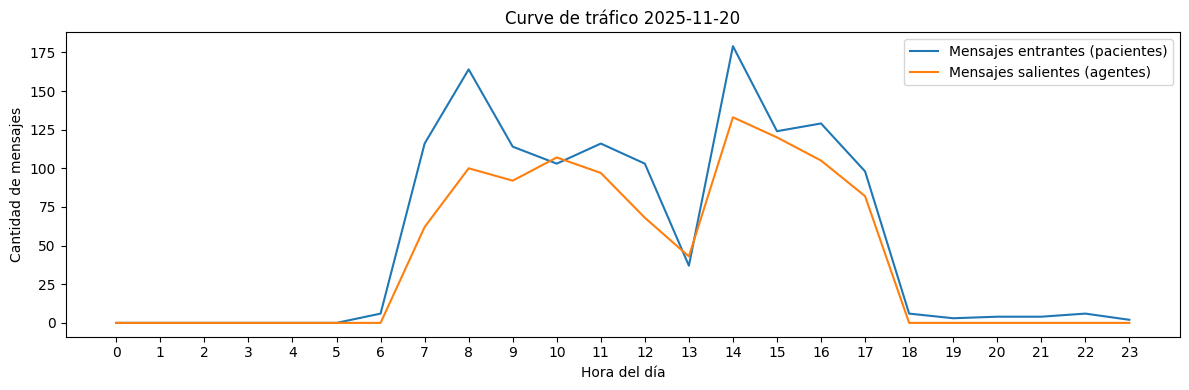

In [64]:
# SET THESE before running:
# messages = ...
# users = ...

import matplotlib.pyplot as plt
import pandas as pd

msgs = messages.copy()

# convert timestamps
msgs["created_at"] = pd.to_datetime(msgs["created_at"], utc=True).dt.tz_convert("America/Bogota")
msgs["date"] = msgs["created_at"].dt.strftime("%Y-%m-%d")
msgs["hour"] = msgs["created_at"].dt.hour

target_date = "2025-11-20"
day_msgs = msgs[msgs["date"] == target_date]

agents_emails = {
    "andres.echeverri@chatwoot.com",
    "diana@chatwoot.com",
    "jenny@chatwoot.com",
    "viviana@chatwoot.com"
}

agents = users[users["email"].isin(agents_emails)][["id","email"]]
agent_ids = set(agents["id"].astype(int).tolist())

incoming = day_msgs[
    (day_msgs["sender_type"]=="Contact") &
    (day_msgs["private"].astype(str)=="f") &
    (day_msgs["message_type"]==0)
]

outgoing = day_msgs[
    (day_msgs["sender_type"]=="User") &
    (day_msgs["sender_id"].isin(agent_ids)) &
    (day_msgs["private"].astype(str)=="f") &
    (day_msgs["message_type"]==1)
]

inc_hour = incoming.groupby("hour")["id"].count()
out_hour = outgoing.groupby("hour")["id"].count()

hours = range(24)
inc_counts = [inc_hour.get(h,0) for h in hours]
out_counts = [out_hour.get(h,0) for h in hours]

plt.figure(figsize=(12,4))
plt.plot(hours, inc_counts, label="Mensajes entrantes (pacientes)")
plt.plot(hours, out_counts, label="Mensajes salientes (agentes)")

plt.title(f"Curve de tráfico {target_date}")
plt.xlabel("Hora del día")
plt.ylabel("Cantidad de mensajes")
plt.xticks(hours)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# concurrency proxy

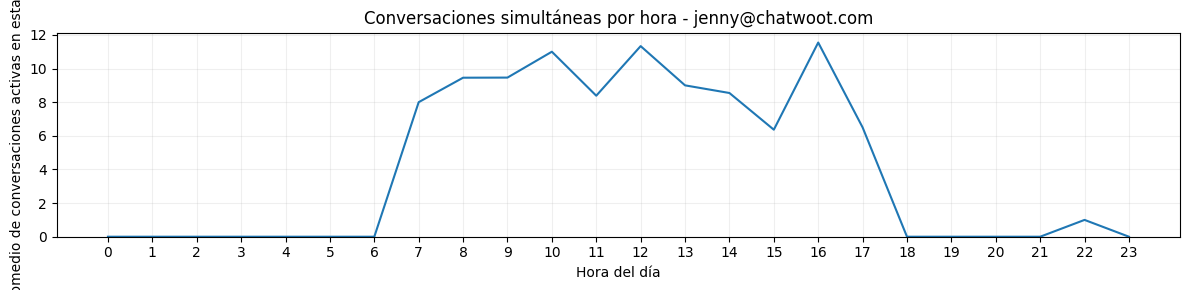

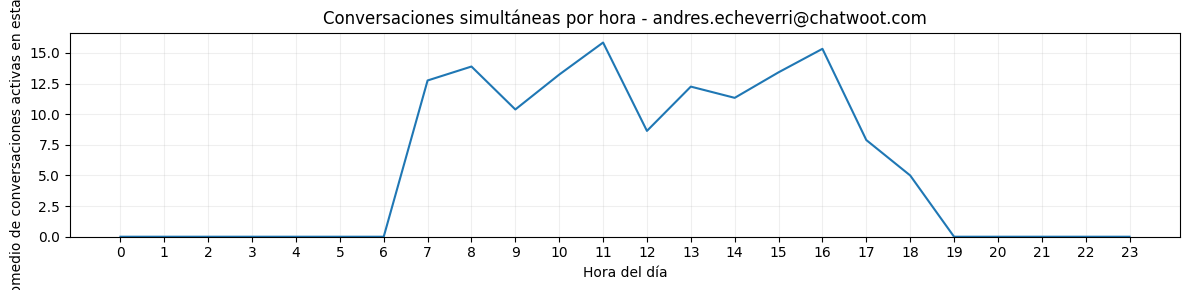

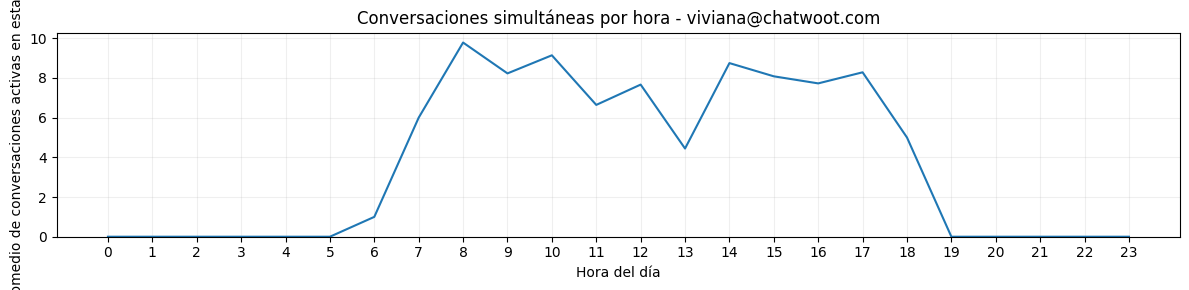

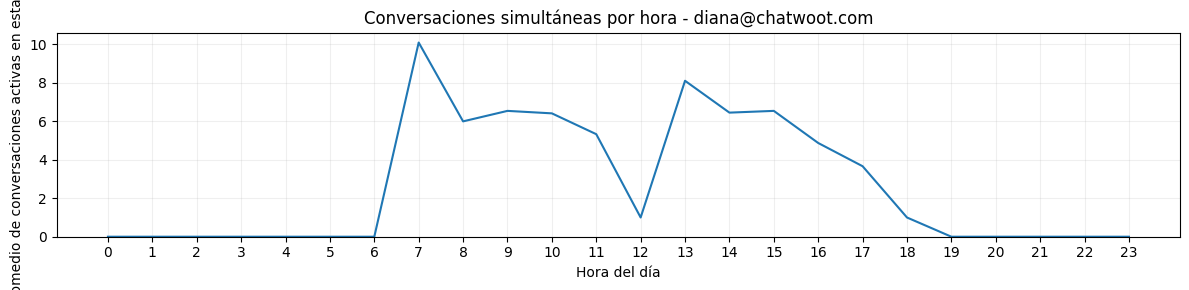

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

LOCAL_TZ = "America/Bogota"
START_DATE_LOCAL = "2025-11-13"
END_DATE_LOCAL   = "2025-12-01"
HOLIDAY_EXCLUDE  = {"2025-11-17"}

agents_emails = {
    "andres.echeverri@chatwoot.com",
    "diana@chatwoot.com",
    "jenny@chatwoot.com",
    "viviana@chatwoot.com"
}

users = chatwoot["users"]
agents = users[users["email"].isin(agents_emails)][["id","email"]].copy()
agent_ids = set(agents["id"].astype(int).tolist())

# ----------------------- MESSAGES -----------------------
m = chatwoot["messages"].copy()
m["created_at"] = pd.to_datetime(m["created_at"], utc=True).dt.tz_convert(LOCAL_TZ)
m["date"] = m["created_at"].dt.strftime("%Y-%m-%d")
m = m[(m["date"] >= START_DATE_LOCAL) & (m["date"] <= END_DATE_LOCAL)]
m = m[~m["date"].isin(HOLIDAY_EXCLUDE)]

# outbound agent messages
msg_ev = m[
    (m["sender_type"]=="User") &
    (m["sender_id"].isin(agent_ids)) &
    (m["private"].astype(str)=="f")
][["sender_id","conversation_id","created_at"]].copy()

msg_ev["type"] = "message"


# ----------------------- AUDITS -----------------------
a = chatwoot["audits"].copy()
a["created_at"] = pd.to_datetime(a["created_at"], utc=True).dt.tz_convert(LOCAL_TZ)
a["date"] = a["created_at"].dt.strftime("%Y-%m-%d")
a = a[(a["date"] >= START_DATE_LOCAL) & (a["date"] <= END_DATE_LOCAL)]
a = a[~a["date"].isin(HOLIDAY_EXCLUDE)]
a = a[a["user_id"].isin(agent_ids)]

# find conversation id on audit rows
def extract_conv(row):
    if row["auditable_type"]=="Conversation":
        return int(row["auditable_id"])
    if row["associated_type"]=="Conversation":
        return int(row["associated_id"])
    return None

a["conversation_id"] = a.apply(extract_conv, axis=1)
ev_aud = a[a["conversation_id"].notna()][["user_id","conversation_id","created_at"]].copy()
ev_aud.rename(columns={"user_id":"sender_id"}, inplace=True)
ev_aud["type"] = "audit"


# ----------------------- MERGE EVENTS -----------------------
ev = pd.concat([msg_ev, ev_aud], ignore_index=True)
ev["date"] = ev["created_at"].dt.strftime("%Y-%m-%d")
ev["hour"] = ev["created_at"].dt.hour

# ----------------------- COMPUTE DISTINCT CONVERSATIONS -----------------------
hourly_conv = (
    ev.groupby(["sender_id","date","hour"])["conversation_id"]
      .nunique()
      .reset_index()
      .rename(columns={"conversation_id":"distinct_conversations"})
)

hourly_conv = hourly_conv.sort_values(["sender_id","date","hour"])


# ----------------------- PLOTS PER AGENT -----------------------
for _, row in agents.iterrows():
    uid = int(row["id"])
    email = row["email"]
    sub = hourly_conv[hourly_conv["sender_id"]==uid]

    data = sub.groupby("hour")["distinct_conversations"].mean().reindex(range(24), fill_value=0)

    plt.figure(figsize=(12,3))
    plt.plot(data.index, data.values)

    plt.title(f"Conversaciones simultáneas por hora - {email}")
    plt.xlabel("Hora del día")
    plt.ylabel("Promedio de conversaciones activas en esta hora")
    plt.xticks(range(24))
    plt.ylim(bottom=0)

    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

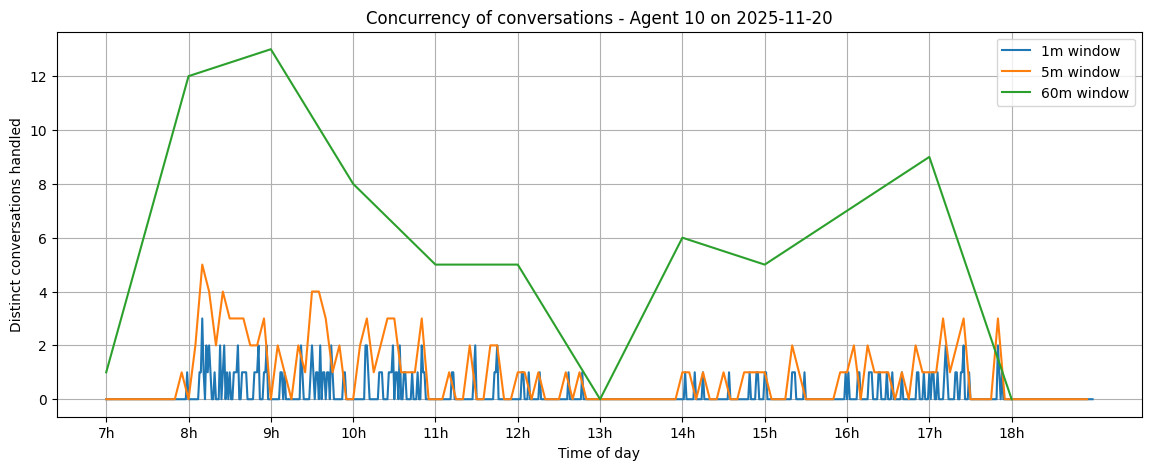

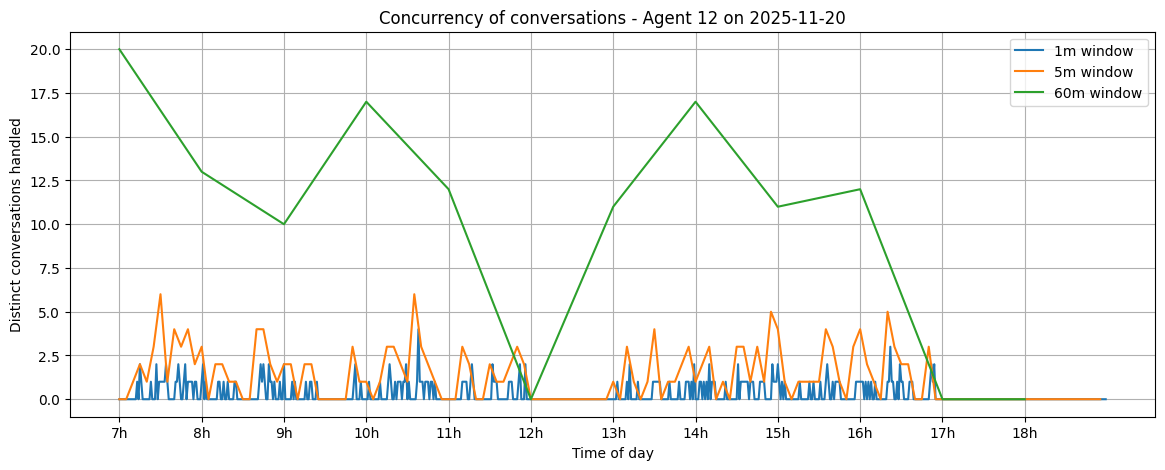

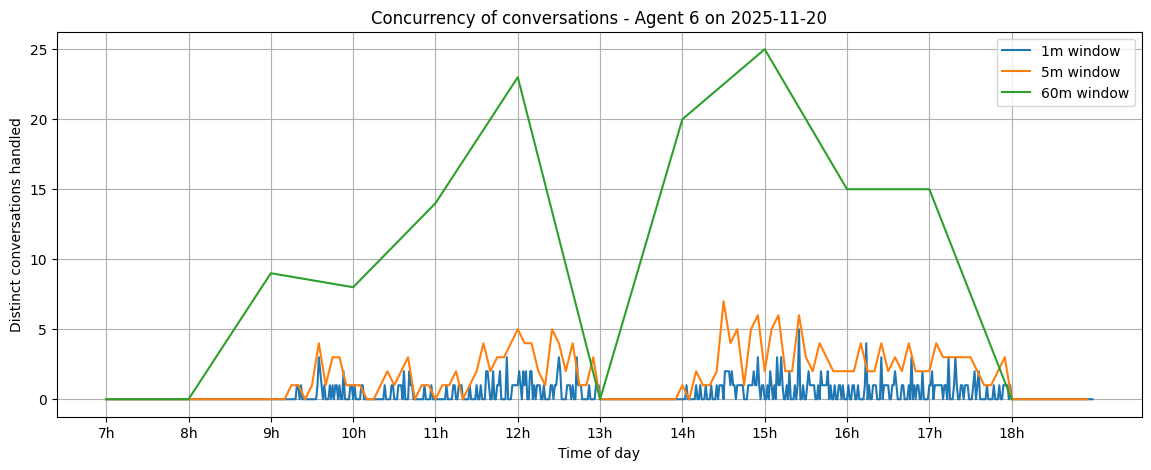

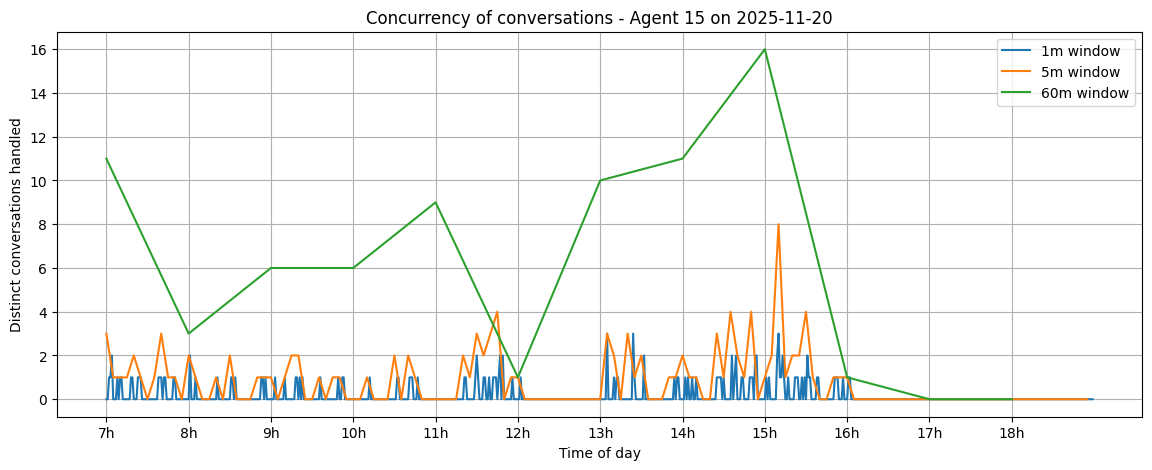

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

LOCAL_TZ = "America/Bogota"
TARGET_DATE = "2025-11-20"

WINDOWS = {
    "1m": "1min",
    "5m": "5min",
    "60m": "60min"
}

AGENT_EMAILS = {
    "andres.echeverri@chatwoot.com",
    "diana@chatwoot.com",
    "jenny@chatwoot.com",
    "viviana@chatwoot.com"
}

agent_users = users[users["email"].isin(AGENT_EMAILS)]
agent_ids = set(agent_users["id"])

msgs = chatwoot["messages"].copy()
msgs["created_at"] = pd.to_datetime(msgs["created_at"], utc=True).dt.tz_convert(LOCAL_TZ)
msgs["date"] = msgs["created_at"].dt.date.astype(str)

msgs = msgs[
    (msgs["date"] == TARGET_DATE) &
    (msgs["sender_type"] == "User") &
    (msgs["sender_id"].isin(agent_ids))
][["sender_id", "created_at", "conversation_id"]].copy()

msgs = msgs.sort_values("created_at")

def compute_curve(df_agent, rule):
    tmp = (
        df_agent
        .set_index("created_at")
        .groupby(pd.Grouper(freq=rule))["conversation_id"]
        .nunique()
        .to_frame(name=rule)
        .between_time("07:00", "18:59")
    )

    full_range = pd.date_range(
        start=f"{TARGET_DATE} 07:00:00",
        end=f"{TARGET_DATE} 18:59:59",
        freq=rule,
        tz=LOCAL_TZ
    )

    return tmp.reindex(full_range).fillna(0)

def label_hours(ax):
    ax.set_xticks(
        [pd.Timestamp(f"{TARGET_DATE} {h:02d}:00:00", tz=LOCAL_TZ) for h in range(7,19)]
    )
    ax.set_xticklabels([f"{h}h" for h in range(7,19)])

for agent_id in agent_ids:
    df_agent = msgs[msgs["sender_id"] == agent_id].copy()
    if df_agent.empty:
        continue

    fig, ax = plt.subplots(figsize=(14,5))
    ax.set_title(f"Concurrency of conversations - Agent {agent_id} on {TARGET_DATE}")

    for label, rule in WINDOWS.items():
        curve = compute_curve(df_agent, rule)
        ax.plot(curve.index, curve[rule], label=f"{label} window")

    label_hours(ax)
    ax.set_ylabel("Distinct conversations handled")
    ax.set_xlabel("Time of day")
    ax.legend()
    ax.grid(True)
    plt.show()

In [ ]:
#FRT

In [84]:
msgs["sender_type"] = (
    msgs["sender_type"]
    .fillna("")
    .astype(str)
    .str.strip()
    .str.capitalize()
)

In [86]:
print("\n=== NORMALIZATION FIX ===")

msgs = chatwoot["messages"].copy()

msgs["created_at"] = pd.to_datetime(msgs["created_at"], utc=True).dt.tz_convert(LOCAL_TZ)

msgs["sender_type"] = (
    msgs["sender_type"]
    .fillna("")
    .astype(str)
    .str.strip()
    .str.capitalize()
)

msgs["private"] = (
    msgs["private"]
    .astype(str)
    .str.lower()
    .map({"t": True, "f": False})
)

msgs["date"] = msgs["created_at"].dt.date.astype(str)

mask_window = (
    (msgs["date"] >= DATE_START) &
    (msgs["date"] <= DATE_END)
)

msgs = msgs[mask_window]

print("[AFTER WINDOW] shape:", msgs.shape)
print("sender_type counts:\n", msgs["sender_type"].value_counts(dropna=False).head())
print("private counts:\n", msgs["private"].value_counts(dropna=False).head())

filtered = msgs[
    msgs["sender_type"].isin(["User","Contact"]) &
    (msgs["private"] == False)
]

print("\n[AFTER FILTER] shape:", filtered.shape)
print(filtered[["sender_type","private"]].head())


=== NORMALIZATION FIX ===
[AFTER WINDOW] shape: (37106, 20)
sender_type counts:
 User       15188
Contact    12296
            9622
Name: sender_type, dtype: int64
private counts:
 False    33560
True      3546
Name: private, dtype: int64

[AFTER FILTER] shape: (24023, 20)
  sender_type  private
0        User    False
1     Contact    False
2        User    False
3     Contact    False
4     Contact    False


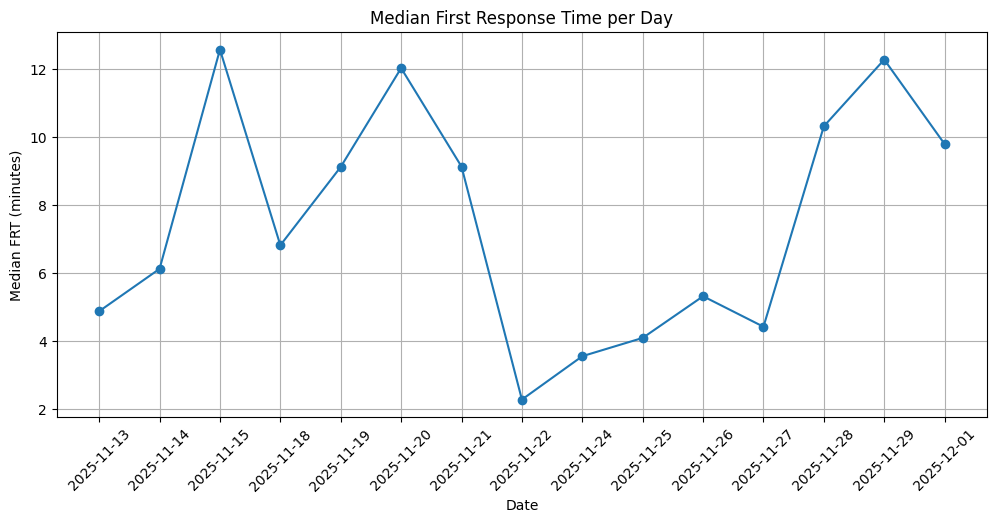

,date,avg,median,p90,p95,pct_under_3,pct_under_5,pct_under_10,sample_size
0,2025-11-13,8.490186,4.871625,21.870168,25.782301,39.393939,51.515152,67.676768,99
1,2025-11-14,9.479647,6.117839,21.417933,29.918332,26.506024,38.554217,67.469880,83
2,2025-11-15,16.293644,12.566367,34.331550,35.945775,3.846154,15.384615,38.461538,26
3,2025-11-18,16.654305,6.812498,46.372937,62.526555,32.638889,43.750000,54.166667,144
4,2025-11-19,16.679234,9.115648,42.013875,58.846271,17.647059,32.773109,52.100840,119
5,2025-11-20,17.424726,12.021033,46.485331,58.080441,21.621622,31.531532,45.045045,111
6,2025-11-21,13.184135,9.125738,32.335760,36.098967,21.951220,29.268293,52.439024,82
7,2025-11-22,3.393526,2.273742,8.383645,9.238399,65.000000,75.000000,95.000000,20
8,2025-11-24,5.785050,3.549350,14.296950,16.320011,47.008547,58.119658,76.068376,117
9,2025-11-25,5.185186,4.086952,11.450470,13.773269,43.055556,58.333333,87.500000,72


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CONFIG
LOCAL_TZ = "America/Bogota"
DATE_START = "2025-11-13"
DATE_END   = "2025-12-01"
HOLIDAYS = {"2025-11-17"}

# Normalize helper
def normalize_messages(df):
    df = df.copy()
    
    df["created_at"] = (
        pd.to_datetime(df["created_at"], utc=True)
        .dt.tz_convert(LOCAL_TZ)
    )

    df["sender_type"] = (
        df["sender_type"]
        .fillna("")
        .astype(str)
        .str.strip()
        .str.capitalize()
    )

    df["private"] = (
        df["private"]
        .astype(str)
        .str.lower()
        .map({"t": True, "f": False})
    )

    df["date"] = df["created_at"].dt.date.astype(str)
    df["hour"] = df["created_at"].dt.hour
    return df


# Load + normalize
msgs = normalize_messages(chatwoot["messages"])

# Filter date window
msgs = msgs[
    (msgs["date"] >= DATE_START) &
    (msgs["date"] <= DATE_END)
]

# Public, real messages only
msgs = msgs[
    msgs["sender_type"].isin(["User","Contact"]) &
    (msgs["private"] == False)
]

# Allowed working days (exclude Sundays + holiday)
valid_dates = sorted(set(msgs["date"]))
valid_dates = [
    d for d in valid_dates
    if pd.Timestamp(d).weekday() != 6 and d not in HOLIDAYS
]

results = []

# Process per day
for day in valid_dates:
    df = msgs[msgs["date"] == day]

    # First patient message
    conv_start = (
        df[df["sender_type"]=="Contact"]
        .groupby("conversation_id")["created_at"]
        .min()
        .rename("contact_first_msg_time")
    )

    # First agent reply
    agent_reply = (
        df[df["sender_type"]=="User"]
        .groupby("conversation_id")["created_at"]
        .min()
        .rename("agent_first_reply_time")
    )

    merged = conv_start.to_frame().join(agent_reply, how="inner")

    # Only convos opened 7:00–16:59
    cond_open = merged["contact_first_msg_time"].dt.hour.between(7,16)

    # Only convos replied 7:00–18:59
    cond_reply = merged["agent_first_reply_time"].dt.hour.between(7,18)

    # reply same day
    cond_same_day = (
        merged["contact_first_msg_time"].dt.date ==
        merged["agent_first_reply_time"].dt.date
    )

    merged = merged[ cond_open & cond_reply & cond_same_day ]
    if merged.empty:
        continue

    merged["FRT_min"] = (
        (merged["agent_first_reply_time"] - merged["contact_first_msg_time"])
        .dt.total_seconds() / 60
    )

    # Hard cap outliers > 2h
    merged = merged[ merged["FRT_min"].between(0.05,120) ]
    if merged.empty:
        continue

    # IQR Outlier removal
    Q1 = merged["FRT_min"].quantile(0.25)
    Q3 = merged["FRT_min"].quantile(0.75)
    IQR = Q3 - Q1
    low_fence = Q1 - 1.5 * IQR
    high_fence = Q3 + 1.5 * IQR

    merged = merged[
        merged["FRT_min"].between(low_fence, high_fence)
    ]
    if merged.empty:
        continue

    results.append({
        "date": day,
        "avg": merged["FRT_min"].mean(),
        "median": merged["FRT_min"].median(),
        "p90": merged["FRT_min"].quantile(0.90),
        "p95": merged["FRT_min"].quantile(0.95),
        "pct_under_3": (merged["FRT_min"] <= 3).mean() * 100,
        "pct_under_5": (merged["FRT_min"] <= 5).mean() * 100,
        "pct_under_10": (merged["FRT_min"] <= 10).mean() * 100,
        "sample_size": merged.shape[0],
    })


FRT_df = pd.DataFrame(results).sort_values("date").reset_index(drop=True)

# Plot median evolution
plt.figure(figsize=(12,5))
plt.plot(FRT_df["date"], FRT_df["median"], marker="o")
plt.xticks(rotation=45)
plt.ylabel("Median FRT (minutes)")
plt.xlabel("Date")
plt.title("Median First Response Time per Day")
plt.grid(True)
plt.show()

FRT_df

In [90]:
import pandas as pd
import numpy as np

LOCAL_TZ = "America/Bogota"
WORK_START = 7
WORK_END = 17
HOLIDAYS = {"2025-11-17"}
WINDOW_START = f"{WORK_START:02d}:00:00"
WINDOW_END = f"{WORK_END:02d}:59:59"

# --------------------------------------------------------------------
# Helper: check if datetime is in working hours
# --------------------------------------------------------------------
def in_working_hours(ts):
    h = ts.hour
    return WORK_START <= h <= WORK_END

# --------------------------------------------------------------------
# 1) Filter only Nov 13 → Dec 01
# --------------------------------------------------------------------
msgs_period = msgs[
    (msgs["date"] >= "2025-11-13") &
    (msgs["date"] <= "2025-12-01")
].copy()

# --------------------------------------------------------------------
# 2) Drop Sundays + Holiday
# --------------------------------------------------------------------
msgs_period["weekday"] = pd.to_datetime(msgs_period["date"]).dt.weekday
msgs_period = msgs_period[
    (msgs_period["weekday"] != 6) &                   # exclude Sundays
    (~msgs_period["date"].isin(HOLIDAYS))             # exclude holiday
].copy()

# --------------------------------------------------------------------
# 3) Split inbound vs outbound
# --------------------------------------------------------------------
contact_inbound = msgs_period[
    (msgs_period["sender_type"] == "Contact") &
    (msgs_period["private"] == False)
].copy()

agent_reply = msgs_period[
    (msgs_period["sender_type"] == "User") &
    (msgs_period["private"] == False)
].copy()

# --------------------------------------------------------------------
# 4) Earliest inbound per conv/day inside working hours
# --------------------------------------------------------------------
contact_inbound = contact_inbound[contact_inbound["created_at"].apply(in_working_hours)]

first_inbound = (
    contact_inbound
    .sort_values("created_at")
    .groupby(["conversation_id","date"], as_index=False)
    .first()
    [["conversation_id", "date", "created_at"]]
    .rename(columns={"created_at": "inbound_time"})
)

# --------------------------------------------------------------------
# 5) Merge with all agent replies same date and same conv
# --------------------------------------------------------------------
merged = first_inbound.merge(
    agent_reply,
    on=["conversation_id","date"],
    suffixes=("_in","_agent"),
)

# Keep only replies AFTER inbound
merged = merged[merged["created_at"] > merged["inbound_time"]]

# Keep only replies within working hours
merged = merged[merged["created_at"].apply(in_working_hours)]

# Keep only the first reply per conv/day
first_reply = (
    merged
    .sort_values("created_at")
    .groupby(["conversation_id","date"], as_index=False)
    .first()
    [["conversation_id","date","inbound_time","created_at"]]
    .rename(columns={"created_at": "reply_time"})
)

# --------------------------------------------------------------------
# 6) Compute ORT (in minutes)
# --------------------------------------------------------------------
first_reply["ort_minutes"] = (
    (first_reply["reply_time"] - first_reply["inbound_time"])
    .dt.total_seconds() / 60
)

# Drop negative ORTs (safety net)
first_reply = first_reply[first_reply["ort_minutes"] >= 0]

# --------------------------------------------------------------------
# 7) Remove outliers > 60 min
# --------------------------------------------------------------------
first_reply_clean = first_reply[first_reply["ort_minutes"] <= 60]

In [91]:
def daily_stats(df):
    rows = []
    for d, chunk in df.groupby("date"):
        base = {}
        base["date"] = d
        base["count"] = len(chunk)
        if len(chunk) == 0:
            rows.append(base)
            continue

        base["avg"] = chunk["ort_minutes"].mean()
        base["median"] = chunk["ort_minutes"].median()
        base["p90"] = chunk["ort_minutes"].quantile(0.90)
        base["p95"] = chunk["ort_minutes"].quantile(0.95)

        base["sla_3min"] = (chunk["ort_minutes"] <= 3).mean() * 100
        base["sla_5min"] = (chunk["ort_minutes"] <= 5).mean() * 100
        base["sla_10min"] = (chunk["ort_minutes"] <= 10).mean() * 100

        rows.append(base)

    return pd.DataFrame(rows)

stats = daily_stats(first_reply_clean)
stats

,date,count,avg,median,p90,p95,sla_3min,sla_5min,sla_10min
0,2025-11-13,132,9.571491,4.787720,23.975520,31.017137,41.666667,51.515152,64.393939
1,2025-11-14,130,13.165599,6.148581,42.456171,48.746941,33.076923,41.538462,61.538462
2,2025-11-15,40,13.887670,10.924758,34.318858,36.682999,20.000000,27.500000,45.000000
3,2025-11-18,182,12.850032,5.372366,36.832233,44.233672,36.813187,48.901099,59.890110
4,2025-11-19,152,13.967770,8.001866,35.185934,44.624232,23.684211,38.815789,56.578947
5,2025-11-20,156,11.866970,6.790628,32.104144,44.010869,32.051282,41.025641,58.333333
6,2025-11-21,117,10.758994,6.504886,30.008057,35.491182,37.606838,43.589744,61.538462
7,2025-11-22,41,7.384963,4.072775,19.544557,20.658936,43.902439,56.097561,70.731707
8,2025-11-24,167,6.432641,3.315361,16.656413,21.722620,48.502994,58.682635,74.850299
9,2025-11-25,125,7.072788,4.263110,16.441092,23.456486,41.600000,56.800000,80.800000


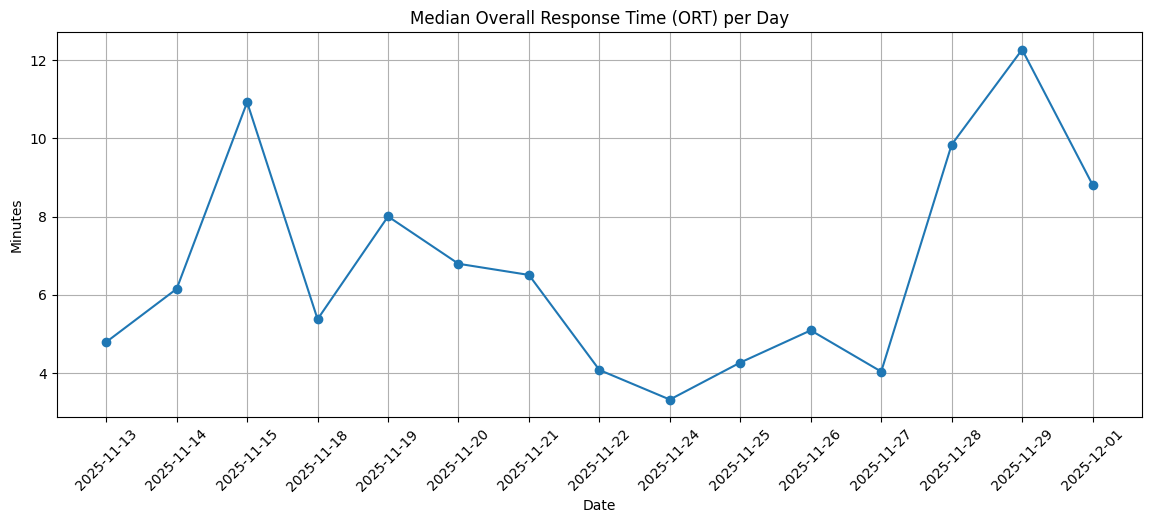

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(stats["date"], stats["median"], marker='o')
plt.title("Median Overall Response Time (ORT) per Day")
plt.ylabel("Minutes")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# 📌 Contact–Side Response Times (CRT) FRT and ORT

In [95]:
import pandas as pd
import numpy as np

# ========================================================
# CONFIG
# ========================================================

LOCAL_TZ = "America/Bogota"

AGENT_EMAILS = {
    "andres.echeverri@chatwoot.com",
    "diana@chatwoot.com",
    "jenny@chatwoot.com",
    "viviana@chatwoot.com"
}

# Business window
START_HOUR = 7
END_HOUR = 17

# Holiday + Sundays to exclude
BAD_DATES = {
    "2025-11-17"  # holiday (already confirmed)
}

# Active date range for your dataset
DATE_MIN = "2025-11-13"
DATE_MAX = "2025-12-01"


# ========================================================
# 1) Identify Agents by user_id
# ========================================================
agent_users = users[users["email"].isin(AGENT_EMAILS)]
agent_ids = set(agent_users["id"])

print("=== AGENTS FOUND ===")
print(agent_users[["id","email"]], "\n")


# ========================================================
# 2) Normalize and filter messages dataset
# ========================================================
df = msgs.copy()

df["created_at"] = (
    pd.to_datetime(df["created_at"], utc=True)
      .dt.tz_convert(LOCAL_TZ)
)

df["date"] = df["created_at"].dt.date.astype(str)
df["hour"] = df["created_at"].dt.hour

# Keep only within global window
df = df[
    (df["date"] >= DATE_MIN) &
    (df["date"] <= DATE_MAX)
]

# Remove Sundays
is_sunday = pd.to_datetime(df["date"]).dt.dayofweek == 6
df = df[~is_sunday]

# Remove holiday(s)
df = df[~df["date"].isin(BAD_DATES)]

# Only non-private messages
df = df[df["private"] == False]

# Must have sender_type and conversation
df = df[
    df["sender_type"].isin(["Contact","User"]) &
    df["conversation_id"].notna()
]

print(f"[AFTER FILTERING] Shape: {df.shape}")
print(df["sender_type"].value_counts(), "\n")


# ========================================================
# 3) Extract candidate conversations
#    * First contact message inside business hours
# ========================================================

# Contact messages
contact_msgs = df[df["sender_type"] == "Contact"].copy()

# Only first message per conversation
first_contact = (
    contact_msgs
    .sort_values("created_at")
    .groupby("conversation_id")
    .first()
    .reset_index()
)

# Filter working hours for first contact
first_contact = first_contact[
    first_contact["created_at"].dt.hour.between(START_HOUR, END_HOUR)
]

print(f"[FIRST CONTACT CANDIDATES] {first_contact.shape}")
print(first_contact[["conversation_id","created_at"]].head(), "\n")


# ========================================================
# 4) Find agent reply AFTER first contact
# ========================================================

# Agent messages only
agent_msgs = df[
    (df["sender_type"] == "User") &
    (df["sender_id"].isin(agent_ids))
][
    ["conversation_id","created_at","sender_id"]
].copy()

agent_msgs = agent_msgs.sort_values(["conversation_id","created_at"])


rows = []
for _, row in first_contact.iterrows():
    c_id = row["conversation_id"]
    c_time = row["created_at"]
    c_date = row["date"]

    # Agent replies same conversation, same date, after contact
    replies = agent_msgs[
        (agent_msgs["conversation_id"] == c_id) &
        (agent_msgs["created_at"] > c_time) &
        (agent_msgs["created_at"].dt.date.astype(str) == c_date)
    ]

    if replies.empty:
        continue

    first_reply = replies.iloc[0]
    delta = (first_reply["created_at"] - c_time).total_seconds() / 60.0

    rows.append({
        "conversation_id": c_id,
        "date": c_date,
        "first_contact_time": c_time,
        "first_agent_reply_time": first_reply["created_at"],
        "agent_id": first_reply["sender_id"],
        "frt_minutes": delta
    })

frt_df = pd.DataFrame(rows)

print(f"[RAW FRT COUNT] {frt_df.shape}")
print(frt_df.head(), "\n")


# ========================================================
# 5) Trim outliers
# ========================================================

# IQR method
Q1 = frt_df["frt_minutes"].quantile(0.25)
Q3 = frt_df["frt_minutes"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

frt_clean = frt_df[
    (frt_df["frt_minutes"] >= lower) &
    (frt_df["frt_minutes"] <= upper)
].copy()

print(f"[AFTER OUTLIER TRIM] {frt_clean.shape}\n")


# ========================================================
# 6) Series per day – median, mean, p90, p95
# ========================================================

daily_stats = (
    frt_clean
    .groupby("date")["frt_minutes"]
    .agg([
        "count","mean","median",
        lambda x: np.percentile(x,90),
        lambda x: np.percentile(x,95),
    ])
    .rename(columns={
        "mean":"mean_fr",
        "median":"median_fr",
        "<lambda_0>":"p90_fr",
        "<lambda_1>":"p95_fr"
    })
)

print("=== DAILY AGENT FRT METRICS ===")
print(daily_stats, "\n")


# ========================================================
# 7) SLA evaluation
# ========================================================

def pct(threshold):
    return (frt_clean["frt_minutes"] <= threshold).mean()*100

sla = {
    "within_3m": pct(3),
    "within_5m": pct(5),
    "within_10m": pct(10)
}

print("=== SLA PERFORMANCE ===")
print(sla, "\n")


# Final output
frt_df = frt_clean.reset_index(drop=True)
print("=== FINAL frt_df READY ===")
print(frt_df.head())
print(f"\nTOTAL VALID CONVERSATIONS: {len(frt_df)}")

=== AGENTS FOUND ===
   id                          email
1  12             jenny@chatwoot.com
2   6  andres.echeverri@chatwoot.com
6  10           viviana@chatwoot.com
7  15             diana@chatwoot.com 

[AFTER FILTERING] Shape: (23764, 21)
Contact    12122
User       11642
Name: sender_type, dtype: int64 

[FIRST CONTACT CANDIDATES] (1919, 21)
   conversation_id                       created_at
0              725 2025-11-13 07:24:58.267154-05:00
1              726 2025-11-13 07:53:20.026477-05:00
3              728 2025-11-13 07:22:57.785295-05:00
4              730 2025-11-13 07:36:37.175762-05:00
5              731 2025-11-13 07:49:26.228185-05:00 

[RAW FRT COUNT] (1686, 6)
   conversation_id        date               first_contact_time  \
0              725  2025-11-13 2025-11-13 07:24:58.267154-05:00   
1              726  2025-11-13 2025-11-13 07:53:20.026477-05:00   
2              730  2025-11-13 2025-11-13 07:36:37.175762-05:00   
3              731  2025-11-13 2025-11-13


[RAW CRT COUNT] (7457, 5)
   conversation_id        date                   agent_msg_time  \
0              725  2025-11-13 2025-11-13 07:01:13.282339-05:00   
1              725  2025-11-13 2025-11-13 07:02:54.142762-05:00   
2              725  2025-11-13 2025-11-13 07:34:36.865328-05:00   
3              725  2025-11-13 2025-11-13 07:38:54.510194-05:00   
4              725  2025-11-13 2025-11-13 07:41:22.089067-05:00   

                contact_reply_time  crt_minutes  
0 2025-11-13 07:24:58.267154-05:00    23.749747  
1 2025-11-13 07:24:58.267154-05:00    22.068740  
2 2025-11-13 07:43:19.918431-05:00     8.717552  
3 2025-11-13 07:43:19.918431-05:00     4.423471  
4 2025-11-13 07:43:19.918431-05:00     1.963823   

[AFTER OUTLIER TRIM] (6346, 5)

=== CONTACT CRT DAILY METRICS ===
            count  mean_crt  median_crt
date                                   
2025-11-13    484  5.483567    2.526008
2025-11-14    420  4.982275    3.189978
2025-11-15    146  4.626503    1.542276
20

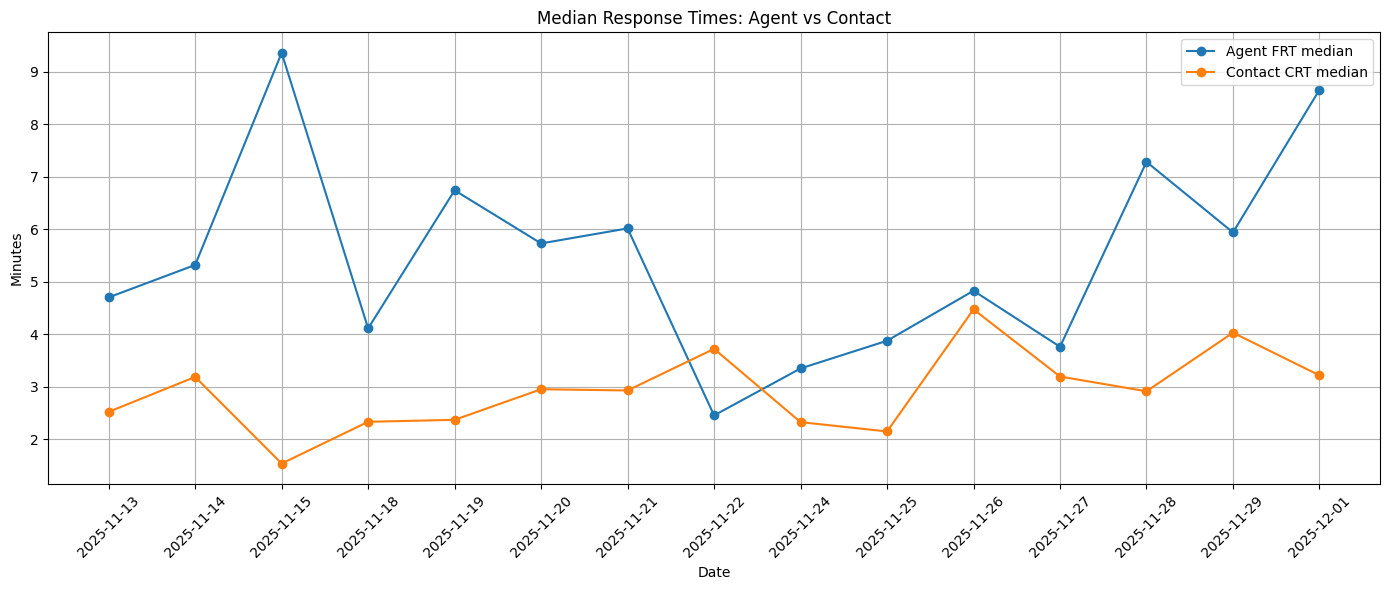

In [96]:
# ========================================================
# CONTACT REPLY TIME (CRT)
# ========================================================

# 1) Filter only messages from agents
agents = df[
    (df["sender_type"] == "User") &
    (df["sender_id"].isin(agent_ids))
].copy()

# Must be chronological
agents = agents.sort_values(["conversation_id","created_at"])


rows = []

# Iterate over each agent message
for _, row in agents.iterrows():
    conv_id = row["conversation_id"]
    t_agent = row["created_at"]
    d_agent = row["date"]

    # Contact reply messages same convo, same date, after agent message
    candidates = df[
        (df["conversation_id"] == conv_id) &
        (df["sender_type"] == "Contact") &
        (df["created_at"] > t_agent) &
        (df["created_at"].dt.date.astype(str) == d_agent) &
        (df["created_at"].dt.hour.between(START_HOUR, END_HOUR))
    ]

    if candidates.empty:
        continue

    first_contact_reply = candidates.iloc[0]
    delta = (first_contact_reply["created_at"] - t_agent).total_seconds()/60.0

    rows.append({
        "conversation_id": conv_id,
        "date": d_agent,
        "agent_msg_time": t_agent,
        "contact_reply_time": first_contact_reply["created_at"],
        "crt_minutes": delta
    })

crt_df = pd.DataFrame(rows)
print(f"\n[RAW CRT COUNT] {crt_df.shape}")
print(crt_df.head(), "\n")

# ========================================================
# Outlier trim
# ========================================================

Q1 = crt_df["crt_minutes"].quantile(0.25)
Q3 = crt_df["crt_minutes"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

crt_clean = crt_df[
    (crt_df["crt_minutes"] >= lower) &
    (crt_df["crt_minutes"] <= upper)
].copy()

print(f"[AFTER OUTLIER TRIM] {crt_clean.shape}")

# ========================================================
# Daily Metrics
# ========================================================

contact_daily = (
    crt_clean
    .groupby("date")["crt_minutes"]
    .agg(["count","mean","median"])
    .rename(columns={
        "mean":"mean_crt",
        "median":"median_crt"
    })
)

print("\n=== CONTACT CRT DAILY METRICS ===")
print(contact_daily)

# ========================================================
# Merge with Agent FRT for plotting
# ========================================================

merged = (
    daily_stats[["median_fr"]]
    .merge(contact_daily[["median_crt"]], how="left", left_index=True, right_index=True)
    .sort_index()
)

print("\n=== MERGED DAILY MEDIANS ===")
print(merged)

# ========================================================
# Plot
# ========================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(merged.index, merged["median_fr"], marker='o', label="Agent FRT median")
plt.plot(merged.index, merged["median_crt"], marker='o', label="Contact CRT median")

plt.title("Median Response Times: Agent vs Contact")
plt.xlabel("Date")
plt.ylabel("Minutes")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
# ===============================================================
# CONTACT FIRST RESPONSE TIME (FRT)
# ===============================================================

df = msgs.copy()
df = df.sort_values(["conversation_id","created_at"])

# First agent message in each conversation within window
first_agent_msg = (
    df[
        (df["sender_type"] == "User") &
        (df["sender_id"].isin(agent_ids))
    ]
    .groupby("conversation_id")
    .head(1)
    .reset_index(drop=True)
)

rows = []

for _, arow in first_agent_msg.iterrows():
    conv = arow["conversation_id"]
    t_agent = arow["created_at"]
    date_agent = arow["date"]

    contact_msgs = df[
        (df["conversation_id"] == conv) &
        (df["sender_type"] == "Contact") &
        (df["created_at"] > t_agent) &
        (df["created_at"].dt.date.astype(str) == date_agent) &
        (df["hour"].between(7,17))
    ]

    if contact_msgs.empty:
        continue

    first_reply = contact_msgs.iloc[0]
    delta = (first_reply["created_at"] - t_agent).total_seconds()/60

    rows.append({
        "conversation_id": conv,
        "date": date_agent,
        "first_agent_msg": t_agent,
        "contact_reply": first_reply["created_at"],
        "contact_frt_min": delta
    })

contact_frt = pd.DataFrame(rows)

# Outlier trimming
Q1 = contact_frt["contact_frt_min"].quantile(0.25)
Q3 = contact_frt["contact_frt_min"].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

contact_frt = contact_frt[
    (contact_frt["contact_frt_min"] >= lower) &
    (contact_frt["contact_frt_min"] <= upper)
]

contact_frt_daily = (
    contact_frt
    .groupby("date")["contact_frt_min"]
    .median()
    .rename("median_contact_frt")
)

In [98]:
# ===============================================================
# CONTACT OVERALL RESPONSE TIME (ORT)
# ===============================================================

rows = []

# isolate contact messages
contacts = df[df["sender_type"] == "Contact"].copy()
contacts = contacts.sort_values(["conversation_id","created_at"])

for _, crow in contacts.iterrows():
    conv = crow["conversation_id"]
    t_contact = crow["created_at"]
    d_contact = crow["date"]

    agent_msgs = df[
        (df["conversation_id"] == conv) &
        (df["sender_type"] == "User") &
        (df["sender_id"].isin(agent_ids)) &
        (df["created_at"] > t_contact) &
        (df["created_at"].dt.date.astype(str) == d_contact) &
        (df["hour"].between(7,17))
    ]

    if agent_msgs.empty:
        continue

    first_agent = agent_msgs.iloc[0]
    delta = (first_agent["created_at"] - t_contact).total_seconds()/60

    rows.append({
        "conversation_id": conv,
        "date": d_contact,
        "contact_msg": t_contact,
        "agent_reply": first_agent["created_at"],
        "contact_ort_min": delta
    })

contact_ort = pd.DataFrame(rows)

# Outlier trimming
Q1 = contact_ort["contact_ort_min"].quantile(0.25)
Q3 = contact_ort["contact_ort_min"].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

contact_ort = contact_ort[
    (contact_ort["contact_ort_min"] >= lower) &
    (contact_ort["contact_ort_min"] <= upper)
]

contact_ort_daily = (
    contact_ort
    .groupby("date")["contact_ort_min"]
    .median()
    .rename("median_contact_ort")
)

In [101]:
# -----------------------------------------------------------
# 1) Merge contact FRT + ORT (per day)
# -----------------------------------------------------------

contact_curves = pd.concat(
    [
        contact_frt_daily.rename("median_contact_frt"),
        contact_ort_daily.rename("median_contact_ort")
    ],
    axis=1
).sort_index()

print("\n=== DAILY CONTACT CURVES ===")
print(contact_curves)


=== DAILY CONTACT CURVES ===
            median_contact_frt  median_contact_ort
date                                              
2025-11-13            1.867948            4.871625
2025-11-14            1.404951            4.809290
2025-11-15            1.254335            5.592371
2025-11-18            1.256850            4.415418
2025-11-19            2.621728            4.710536
2025-11-20            1.273277            6.100859
2025-11-21            1.240418            6.408751
2025-11-22            2.633633            3.204918
2025-11-24            1.228054            4.490415
2025-11-25            1.156988            3.786480
2025-11-26            2.141465            4.255645
2025-11-27            1.633298            4.474757
2025-11-28            2.259828            8.275546
2025-11-29            1.909118            6.436843
2025-12-01            3.058876            9.494706


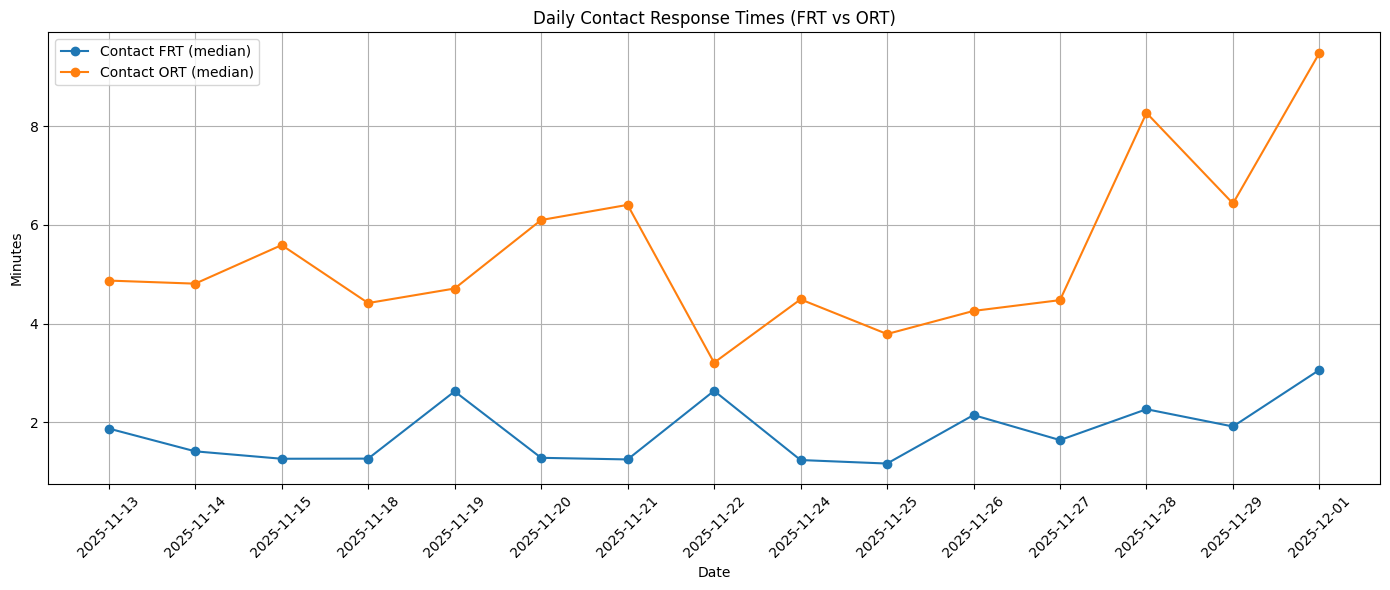

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(
    contact_curves.index,
    contact_curves["median_contact_frt"],
    marker="o",
    label="Contact FRT (median)"
)
plt.plot(
    contact_curves.index,
    contact_curves["median_contact_ort"],
    marker="o",
    label="Contact ORT (median)"
)

plt.title("Daily Contact Response Times (FRT vs ORT)")
plt.xlabel("Date")
plt.ylabel("Minutes")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()